In [29]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import warnings

# Thêm đường dẫn dẫn đến thư mục cha
sys.path.append(os.path.abspath(".."))
warnings.filterwarnings("ignore")

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
IMPORTANT_LMS = [
    "nose",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_pinky",
    "right_pinky",
    "left_index",
    "right_index",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_foot_index",
    "right_foot_index",
]

In [31]:
def square_for_image(path: str):
    # Đọc hình ảnh gốc
    image_path = path  # Thay bằng đường dẫn đến hình ảnh của bạn
    original_image = Image.open(image_path)

    # Kích thước ảnh gốc và ảnh mới
    original_size = original_image.size

    # Kích thước ảnh mới sẽ là kích thước lớn nhất của ảnh gốc
    max_width = max(original_size)

    new_size = (max_width, max_width)

    # Tạo một ảnh mới với nền đen
    new_image = Image.new("RGB", new_size, (0, 0, 0))

    # Dán ảnh gốc vào ảnh mới với khoảng trống màu đen
    new_image.paste(original_image, 
                    ((max_width - original_size[0]) // 2, (max_width - original_size[1]) // 2))

    # convert new_image to cv2 format
    new_image_cv2 = cv2.cvtColor(np.array(new_image), cv2.COLOR_RGB2BGR)

    return new_image_cv2

In [32]:
def draw_landmarks(mp_drawing, mp_pose, image : cv2, pose_landmarks : np.array):
    """
    Vẽ landmarks lên ảnh
    """
    mp_drawing.draw_landmarks(
        image,
        pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 0, 0),  # Màu sắc của các landmark
            thickness=5,  # Độ dày của các đường nối landmark
            circle_radius=5,  # Bán kính của các điểm landmark
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(0, 255, 0),  # Màu sắc của các đường nối
            thickness=5,  # Độ dày của các đường nối
        ),
    )

In [33]:
def extract_key_points_from_image(
    image_path: str, label: str, output_file: str, is_draw_landmarks=False
):
    # Khởi tạo MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        static_image_mode=True, model_complexity=1, smooth_landmarks=True
    )

    image = square_for_image(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Phát hiện pose
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        if is_draw_landmarks:
            draw_landmarks(mp_drawing, mp_pose, image, results.pose_landmarks)
            last_dot_index = image_path.rfind(".")
            image_path_output = image_path[:last_dot_index] + "_landmarks" + image_path[last_dot_index:]
            cv2.imwrite(image_path_output, image) # Lưu ảnh đã vẽ landmark

        # Lưu lại toạ độ các key points sau khi dịch chuyển vào csv
        columns_name = ["label"]
        columns_value = [label]
        for id, landmark in enumerate(results.pose_landmarks.landmark):
            land_mark_name = mp_pose.PoseLandmark(id).name.lower()
            
            columns_name += [
                f"{ land_mark_name }_x",
                f"{ land_mark_name }_y",
                f"{ land_mark_name }_z",
            ]

            # landmark.x, landmark.y là các giá trị trước khi dịch chuyển gốc toạ độ vào giữa bức hình
            # Do đó khi đưa gốc toạ độ về giữa bức hình thì phải trừ chúng cho 0.5
            columns_value += [
                landmark.x - 0.5,
                landmark.y - 0.5,
                landmark.z,
            ]

        df_key_points = pd.DataFrame([columns_value], columns=columns_name)

        left_hip = (df_key_points["left_hip_x"], df_key_points["left_hip_y"])
        right_hip = (df_key_points["right_hip_x"], df_key_points["right_hip_y"])

        center_hip = ((left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2)

        nose = (df_key_points["nose_x"], df_key_points["nose_y"])


        # distance between left hip and right hip
        distance = np.sqrt((center_hip[0] - nose[0])**2 + (center_hip[1] - nose[1])**2)

        scale_value = 0.5 / distance

        # Scale all key points
        for id, landmark in enumerate(results.pose_landmarks.landmark):
            land_mark_name = mp_pose.PoseLandmark(id).name.lower()

            df_key_points[f"{ land_mark_name }_x"] = df_key_points[f"{ land_mark_name }_x"] * scale_value
            df_key_points[f"{ land_mark_name }_y"] = df_key_points[f"{ land_mark_name }_y"] * scale_value

        # skip key points that are not important
        df_key_points = df_key_points[["label"] + [f"{landmark}_x" for landmark in IMPORTANT_LMS] + [f"{landmark}_y" for landmark in IMPORTANT_LMS] + [f"{landmark}_z" for landmark in IMPORTANT_LMS]]

        with open(output_file, "a") as f:
            # header=f.tell()==0 sẽ ghi tiêu đề nếu file trống
            df_key_points.to_csv(f, header=f.tell() == 0, index=False)
        
    else:
        print(f"Cannot detect pose in image {image_path}")

    pose.close()

In [34]:
def auto_label_from_folder(folder_path: str, output_file: str, label: str = None):
    """
    Tự động gán nhãn cho các ảnh trong thư mục
    """ 
    # Traverse the folder and process each file
    for root, _, files in os.walk(folder_path):
        print(f"Processing folder {root}")
        for file in files:
            file_path = os.path.join(root, file)
            label = label if label else os.path.basename(root)
            extract_key_points_from_image(file_path, label, output_file)

In [35]:
output_csv = "../../data/key_points_with_scale_zip.csv"

In [36]:
auto_label_from_folder("../../data/1_lie_on", output_csv)

auto_label_from_folder("../../data/2_side", output_csv)

auto_label_from_folder("../../data/3_procumbent", output_csv)

Processing folder ../../data/1_lie_on
Cannot detect pose in image ../../data/1_lie_on\155.jpg
Cannot detect pose in image ../../data/1_lie_on\57.jpg
Processing folder ../../data/2_side
Cannot detect pose in image ../../data/2_side\132.jpg
Cannot detect pose in image ../../data/2_side\52.jpg
Cannot detect pose in image ../../data/2_side\664.jpg
Cannot detect pose in image ../../data/2_side\99.jpg
Processing folder ../../data/3_procumbent
Cannot detect pose in image ../../data/3_procumbent\101.jpg
Cannot detect pose in image ../../data/3_procumbent\104.jpg
Cannot detect pose in image ../../data/3_procumbent\129.jpg
Cannot detect pose in image ../../data/3_procumbent\130.jpg
Cannot detect pose in image ../../data/3_procumbent\136.jpg
Cannot detect pose in image ../../data/3_procumbent\144.jpg
Cannot detect pose in image ../../data/3_procumbent\147.jpg
Cannot detect pose in image ../../data/3_procumbent\16.jpg
Cannot detect pose in image ../../data/3_procumbent\2.jpg
Cannot detect pose in 

In [37]:
df = pd.read_csv(output_csv)

<Axes: xlabel='label', ylabel='count'>

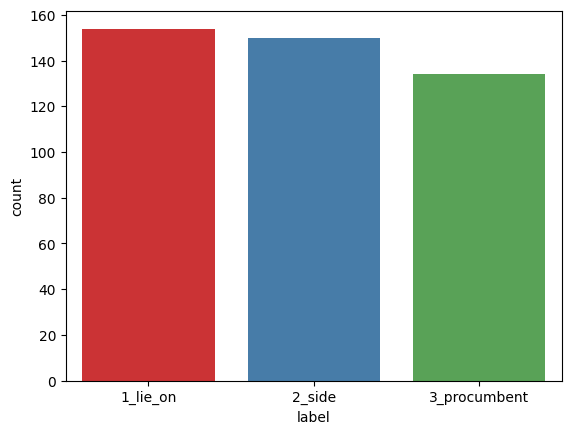

In [38]:
sns.countplot(data=df, x="label", palette="Set1")